<a href="https://colab.research.google.com/github/atropass/pan-sharpening/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# high-resolution grayscale
gray_image = cv2.imread('GRAY.JPG', cv2.IMREAD_GRAYSCALE)

# lower-resolution colored images
rgb_half_image = cv2.imread('RGB_half.JPG')
rgb_quater_image = cv2.imread('RGB_quater.JPG')

1. Align the images
2. Resize the images
3. Color restoration
4. Comparing the results

In [3]:
#SIFT detector
sift = cv2.SIFT_create()

In [4]:
# detecting features using SIFT
keypoints_gray, descriptors_gray = sift.detectAndCompute(gray_image, None)
keypoints_half, descriptors_half = sift.detectAndCompute(rgb_half_image, None)
keypoints_quarter, descriptors_quarter = sift.detectAndCompute(rgb_quater_image, None)

In [5]:
#feature matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

In [6]:
#match descriptors between grayscale and color images
matches_half = bf.match(descriptors_gray, descriptors_half)
matches_quarter = bf.match(descriptors_gray, descriptors_quarter)

In [7]:
#sorting matches based ondistance
matches_half = sorted(matches_half, key = lambda x:x.distance)
matches_quarter = sorted(matches_quarter, key = lambda x:x.distance)

So, using SIFT I detected keypoints and descriptors of all images, after usinn Brute Force mathcing ( bruteforce in this case good because straightforward and actually these images are the same with some rotation )

In [8]:
#good matches
points_gray_half = np.zeros((len(matches_half), 2), dtype=np.float32)
points_half = np.zeros((len(matches_half), 2), dtype=np.float32)

In [9]:
for i, match in enumerate(matches_half):
    points_gray_half[i, :] = keypoints_gray[match.queryIdx].pt
    points_half[i, :] = keypoints_half[match.trainIdx].pt

In [10]:
#find homography
h_half, _ = cv2.findHomography(points_half, points_gray_half, cv2.RANSAC)

In [11]:
points_gray_quarter = np.zeros((len(matches_quarter), 2), dtype=np.float32)
points_quarter = np.zeros((len(matches_quarter), 2), dtype=np.float32)

In [12]:
for i, match in enumerate(matches_quarter):
    points_gray_quarter[i, :] = keypoints_gray[match.queryIdx].pt
    points_quarter[i, :] = keypoints_quarter[match.trainIdx].pt

In [13]:
h_quarter, _ = cv2.findHomography(points_quarter, points_gray_quarter, cv2.RANSAC)

In [14]:
aligned_half = cv2.warpPerspective(rgb_half_image, h_half, (gray_image.shape[1], gray_image.shape[0]))
aligned_quarter = cv2.warpPerspective(rgb_quater_image, h_quarter, (gray_image.shape[1], gray_image.shape[0]))

here, I computer homography for both images ( out transformation matrix ) and after aligned it to our grayscale image and it rotated 2 images properly


Pan sharpening

In [15]:
# converting from RBG to HSV color space
hsv_half = cv2.cvtColor(aligned_half, cv2.COLOR_BGR2HSV)
hsv_quarter = cv2.cvtColor(aligned_quarter, cv2.COLOR_BGR2HSV)

In [16]:
hsv_half[:, :, 2] = gray_image
hsv_quarter[:, :, 2] = gray_image

In [17]:
pan_sharpened_half = cv2.cvtColor(hsv_half, cv2.COLOR_HSV2BGR)
pan_sharpened_quarter = cv2.cvtColor(hsv_quarter, cv2.COLOR_HSV2BGR)

here, I used pan sharpening, firstly converted our 2 images to HSV and after replaced V (value) channel with our grayscale image. keeping hue and saturation of images

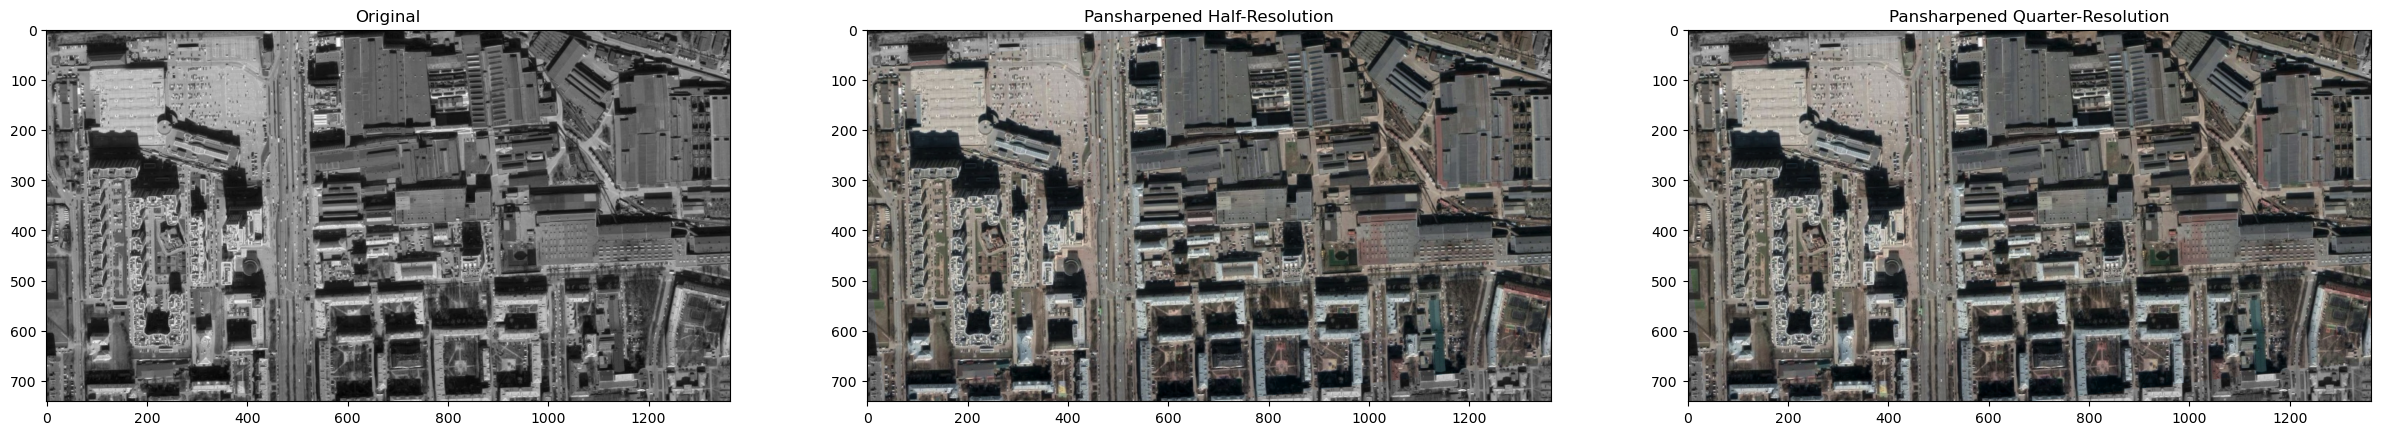

In [18]:
plt.figure(figsize=(30,15))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB))
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(pan_sharpened_half, cv2.COLOR_BGR2RGB))
plt.title('Pansharpened Half-Resolution')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(pan_sharpened_quarter, cv2.COLOR_BGR2RGB))
plt.title('Pansharpened Quarter-Resolution')
plt.show()

In [19]:
cv2.imwrite('pan_sharpened_half.JPG', pan_sharpened_half)
cv2.imwrite('pan_sharpened_quarter.JPG', pan_sharpened_quarter)


True

Seeing the results closely I saw improvement in the quality of our 2 images (with colors). The quality of quarter and half are almost identical because the main source of spatial information in both is the same high-resolution grayscale image.

In [47]:
def apply_brovey(color_image, pan_image):
    #rgb channels
    R, G, B = cv2.split(color_image.astype(float))
    sum_rgb = R + G + B
    # some of the channels are zero so we need to avoid division by zero
    sum_rgb[sum_rgb == 0] = 1 
    #Brovey transformation
    R_brovey = (R / sum_rgb) * pan_image
    G_brovey = (G / sum_rgb) * pan_image
    B_brovey = (B / sum_rgb) * pan_image
    #   
    R_brovey = np.clip(R_brovey, 0, 255).astype(np.uint8)
    G_brovey = np.clip(G_brovey, 0, 255).astype(np.uint8)
    B_brovey = np.clip(B_brovey, 0, 255).astype(np.uint8)
    
    # Merging the channels back
    brovey_image = cv2.merge((R_brovey, G_brovey, B_brovey))
    
    return brovey_image

In [48]:
pan_sharpened_half_brovey = apply_brovey(aligned_half, gray_image)
pan_sharpened_quarter_brovey = apply_brovey(aligned_quarter, gray_image)

Text(0.5, 1.0, 'Original')

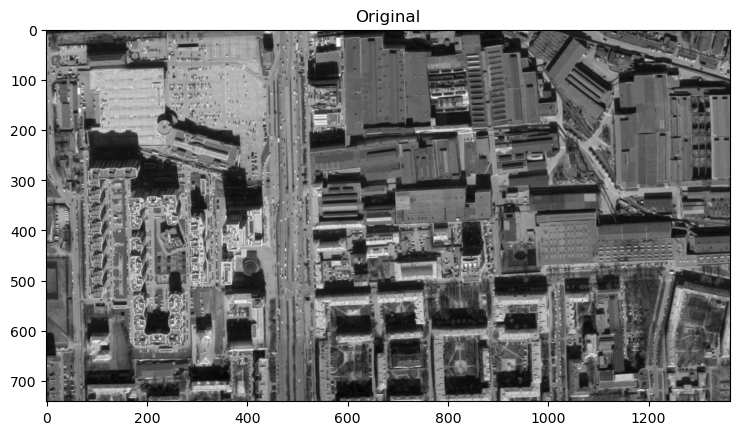

In [50]:
plt.figure(figsize=(30,15))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB))
plt.title('Original')

Text(0.5, 1.0, 'Brovey Pansharpened Half-Resolution')

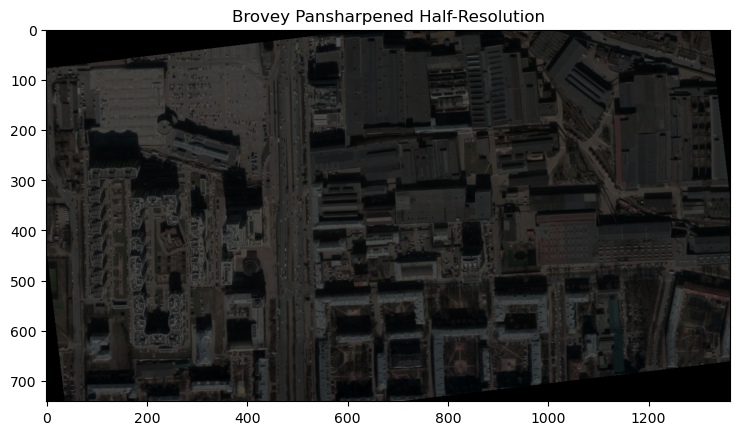

In [51]:
plt.figure(figsize=(30,15))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(pan_sharpened_half_brovey, cv2.COLOR_BGR2RGB))
plt.title('Brovey Pansharpened Half-Resolution')

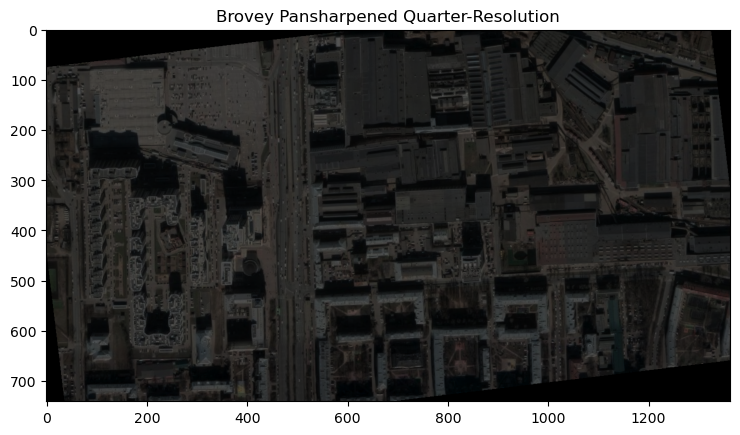

In [52]:
plt.figure(figsize=(30,15))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(pan_sharpened_quarter_brovey, cv2.COLOR_BGR2RGB))
plt.title('Brovey Pansharpened Quarter-Resolution')
plt.show()